In [53]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.colors as colors
plt.style.use('seaborn-poster')

import sys, os
from iminuit import Minuit
import numpy as np; import time; from timeout_decorator import timeout,TimeoutError
import scipy.special as sps
from optparse import OptionParser
from scipy.optimize import fsolve, root
import pickle
from utils import ConfidenceIntervalError

from physt import histogram, binnings, h1, h2, h3

# This is needed to load the environmental variable
import os, subprocess as sp, json
source = 'source /data/ana/BSM/HT_Cascade/FinalAnalysisCode/env.sh'
dump = '/usr/bin/python -c "import os, json;print json.dumps(dict(os.environ))"'
pipe = sp.Popen(['/bin/bash', '-c', '%s && %s' %(source,dump)], stdout=sp.PIPE)
env = json.loads(pipe.stdout.read())
os.environ = env

base_path = os.environ['ANALYSIS_BASE_PATH']
sys.path.append(base_path+'python')

In [2]:
import importlib
halo_spec = importlib.util.find_spec("halo")
halo_found = halo_spec is not None

if halo_found:
    from halo import Halo
    

In [3]:
print (base_path)

/data/ana/BSM/HT_Cascade/FinalAnalysisCode/


In [3]:
LEmasses = [40, 63, 100, 158, 251, 398, 631]
HEmasses = [1000, 1585, 2512, 3981, 6310, 10000, 15850, 25120, 39810]

all_masses = np.append(LEmasses,HEmasses)
LECuts = [0.15,0.2]
HECuts = [-1.0,0.3]
mode = "annihilation"
channel = "nue"
profile = "NFW"
systematics = "nominal"

mass = 1000
if mass in LEmasses:
    LECut,HECut = LECuts
else:
    LECut,HECut = HECuts
print (LECut, HECut)
nOversampling = 100

bins_merge_E   = 2
bins_merge_Psi  = 9


-1.0 0.3


In [4]:
systematics_DM = 'nominal'

DM_file_template = '/PDF_'+systematics_DM+'_DM'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+    '_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(nOversampling)

print (DM_file_template)

/PDF_nominal_DMannihilation_NFWprofile_LEBDT-1.0_HEBDT0.3_2D_nue_1000GeV_oversampling100


In [5]:
dm_path = os.path.join(base_path, "PDFs", "Signal", mode)
dm_scrambled_path = os.path.join(base_path, "PDFs", "ScrambledSignal", mode)

dm_file = 'PDF_' + systematics_DM + '_DM_' + mode + '_' + profile + 'profile_LEBDT' + str(LECut)+'_HEBDT'+str(HECut)+ '_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling' + str(nOversampling)
dm_scrambled_file = 'PDF_' + systematics_DM + '_DM_FullSkyScrambled_' + mode + '_' + profile + 'profile_LEBDT' + str(LECut)+'_HEBDT'+str(HECut)+ '_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling' + str(nOversampling)


In [6]:
h_DM = np.load(os.path.join(dm_path, dm_file+'.pkl'), allow_pickle = True, encoding='latin1')
h_DM_W2 = np.load(os.path.join(dm_path, dm_file+'_quad.pkl'), allow_pickle = True, encoding='latin1')


h_DM_scrambled = np.load(os.path.join(dm_scrambled_path, dm_scrambled_file+'.pkl'), allow_pickle = True, encoding='latin1')
h_DM_scrambled_W2 = np.load(os.path.join(dm_scrambled_path, dm_scrambled_file+'_quad.pkl'), allow_pickle = True, encoding='latin1')

FileNotFoundError: [Errno 2] No such file or directory: '/data/ana/BSM/HT_Cascade/FinalAnalysisCode/PDFs/Signal/annihilation/PDF_nominal_DM_annihilation_NFWprofile_LEBDT-1.0_HEBDT0.3_2D_nue_1000GeV_oversampling100.pkl'

#OLD FILES
h_DM = np.load(base_path+'PDFs/'+mode+'/'+channel+'/'+systematics_DM+DM_file_template+'.pkl', allow_pickle = True, encoding='latin1')
h_DM_W2 = np.load(base_path+'PDFs/'+mode+'/'+channel+'/'+systematics_DM+DM_file_template+'_quad.pkl', allow_pickle=True, encoding='latin1')

h_DM_scrambled = np.load(base_path+'PDFs/ScrambledSignal1/'+mode+'/'+'/PDF_DM_FullSkyScrambled_'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(100)+'.pkl','r', allow_pickle=True, encoding='latin1')
h_DM_scrambled_W2 = np.load(base_path+'PDFs/ScrambledSignal1/'+mode+'/'+'/PDF_DM_FullSkyScrambled_'+mode+'_'+profile+'profile_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_'+channel+'_'+str(int(mass))+'GeV_oversampling'+str(100)+'_quad.pkl','r', allow_pickle=True, encoding='latin1')

In [7]:
bkg_type = 'data'
print ("Loading the histograms with bkg_type: %s"%bkg_type)
bkg_file = os.path.join(base_path, "PDFs", "Data_scrambledFullSky", 'PDF_Data_ScrambleFullSky_LEBDT'+str(LECut)+'_HEBDT'+str(HECut)+'_2D_physt.pkl')

Loading the histograms with bkg_type: data


In [14]:
h_PDF = np.load(bkg_file,'r', allow_pickle=True, encoding='latin1')

AttributeError: module 'numpy.random' has no attribute 'gauss'

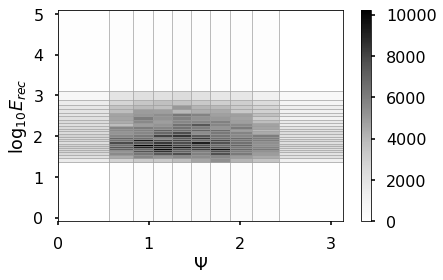

In [56]:
h_Bkg = h_PDF[0] #This is the numpy pdf as usual
hp_Bkg = h_PDF[1] #This is the physt object 

hp_Bkg.plot(density=True, errors=True)

np.random.gauss(231)
print (hp_Bkg.bins)

In [50]:
hp_Bkg_W2 = hp_Bkg.copy()

frec = hp_Bkg.frequencies
ffrec = frec.flatten()
ffrec = ConfidenceIntervalError(ffrec)**2

ffrec = (np.reshape(ffrec, np.shape(frec)))



In [54]:
#hp_Bkg_W2.frequencies = ffrec

hp_Bkg_W2 = h2(frequencies = ffrec)
print(np.sum(hp_Bkg_W2.frequencies))

TypeError: histogram2d() missing 2 required positional arguments: 'data1' and 'data2'

In [16]:
h_Bkg_W2 = [np.array([ConfidenceIntervalError(n)**2 for n in h_Bkg[0]]),h_Bkg[1], h_Bkg[2]]

In [40]:
np.shape(h_Bkg_W2[0])

(48, 90)

In [41]:
from utils import merge_bins

In [42]:
#####################
#
# all PDFs are in units of events!
#
#####################
livetime      = 28272940. + 30674072. + 31511810.5 + 31150852. + 30059465.
hDM     = merge_bins(h_DM, livetime,bins_merge_E, bins_merge_Psi)
hDM_W2    = merge_bins(h_DM_W2, livetime**2,bins_merge_E, bins_merge_Psi) 

hDM_Scram = merge_bins(h_DM_scrambled, livetime,bins_merge_E, bins_merge_Psi)
hDM_Scram_W2 = merge_bins(h_DM_scrambled_W2, livetime**2,bins_merge_E, bins_merge_Psi)

In [43]:
hbkg    = merge_bins(h_Bkg, 1.,bins_merge_E, bins_merge_Psi) 
hbkg_W2  = merge_bins(h_Bkg_W2, 1.,bins_merge_E, bins_merge_Psi)

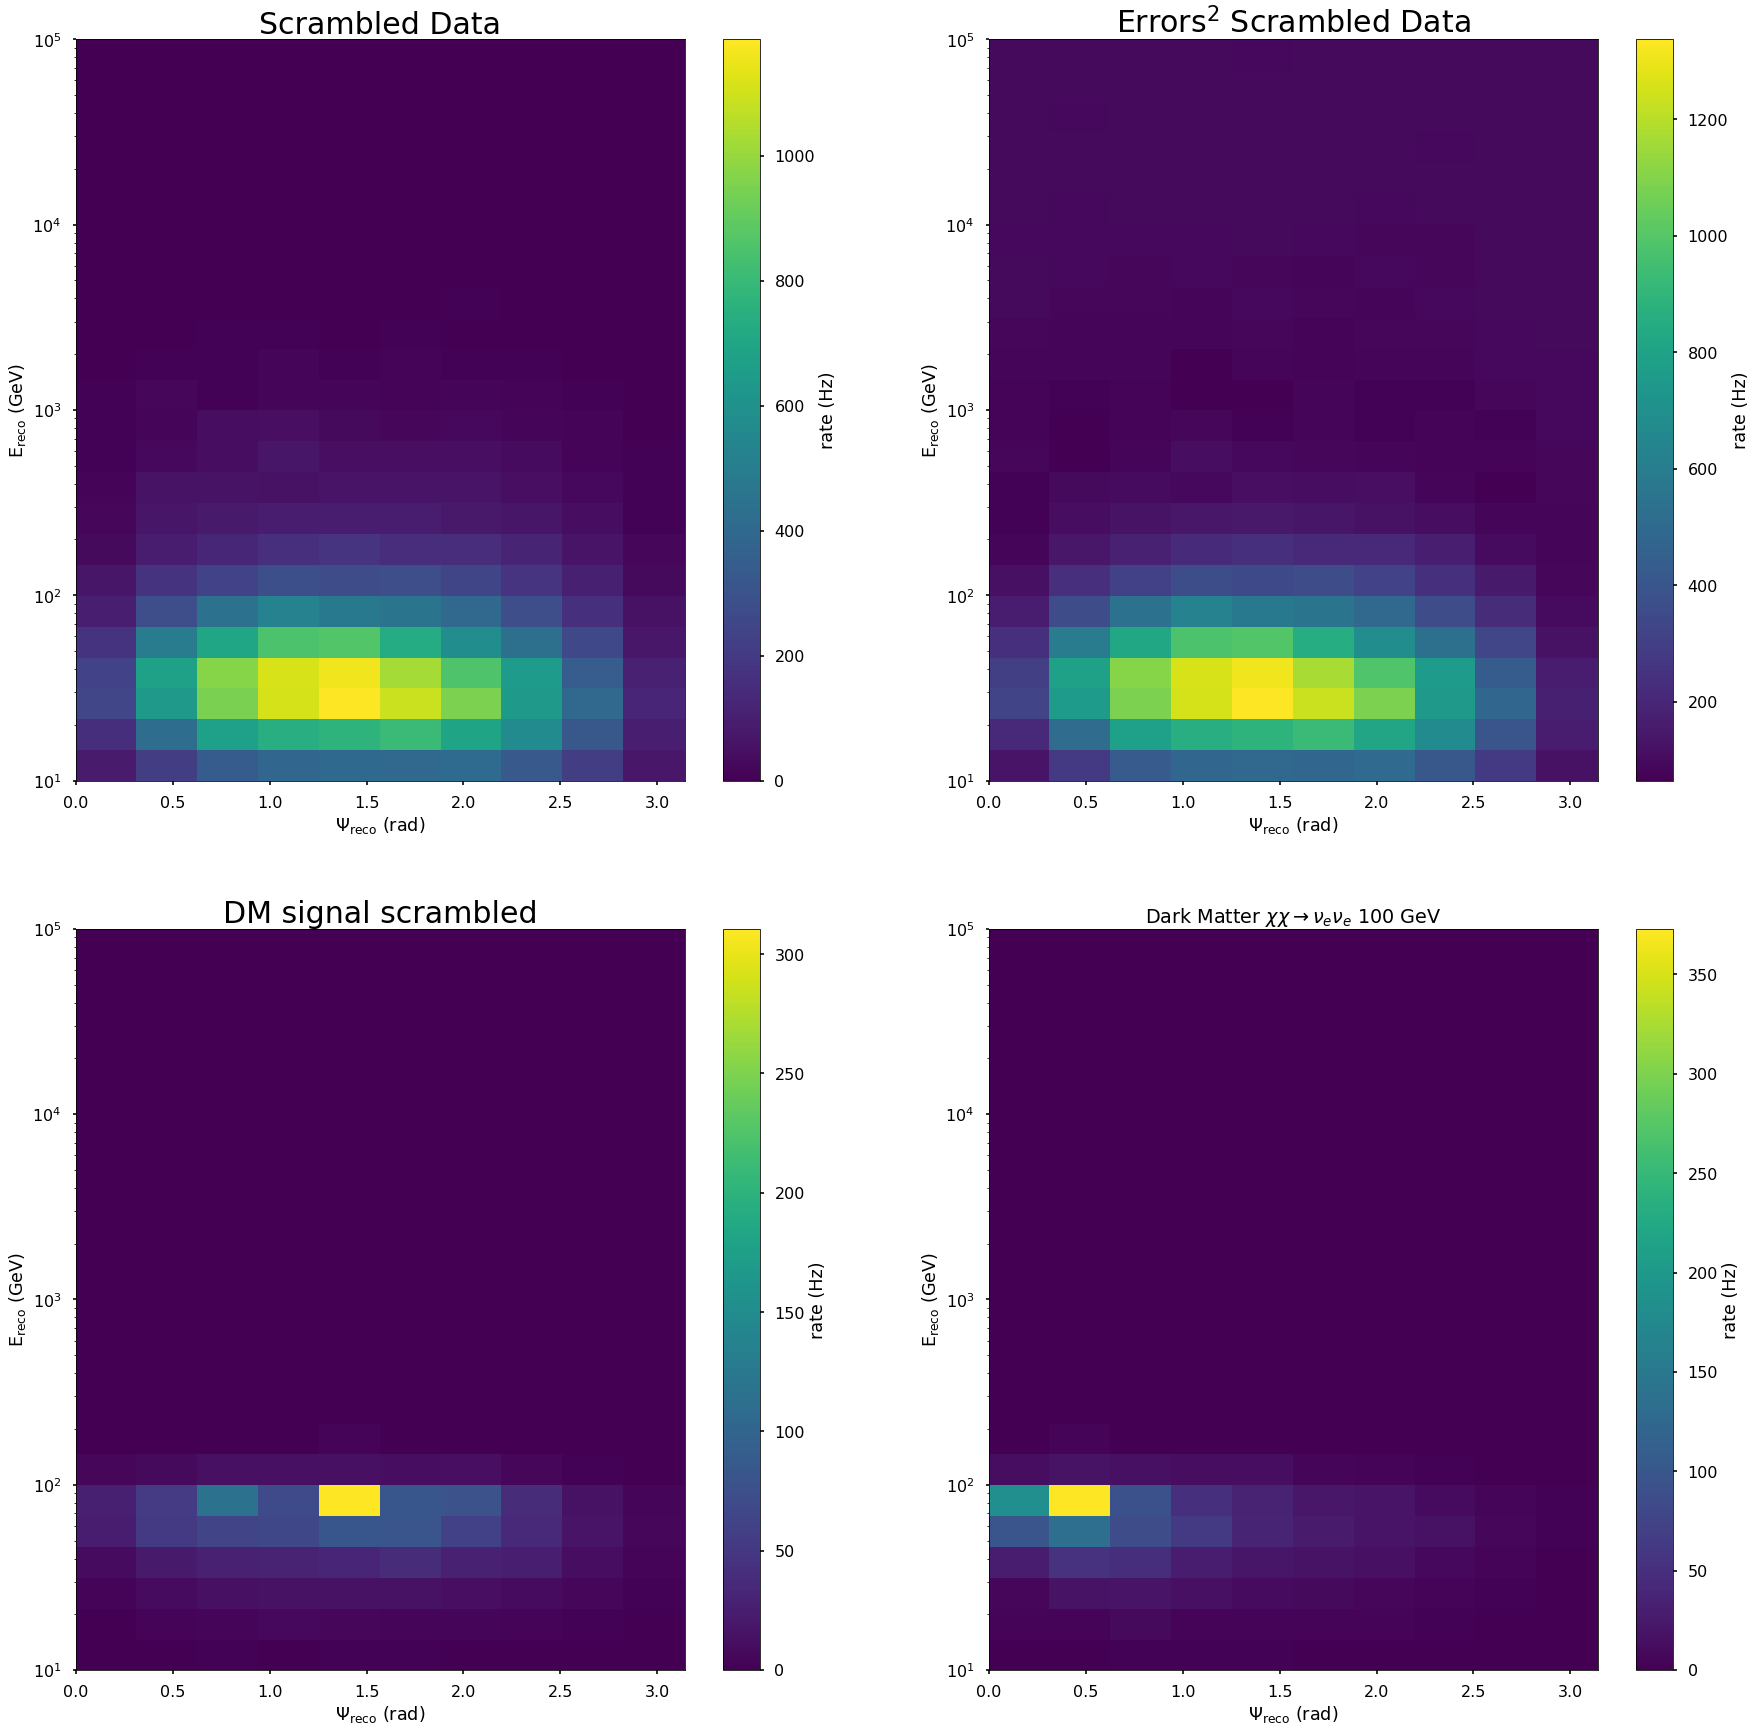

In [44]:


#np.shape(np.array(hatm)[2])

fig,axs = plt.subplots(2,2,figsize=(30,30))
pcm = axs[0,0].pcolormesh(hbkg[2],hbkg[1],hbkg[0])
fig.colorbar(pcm, ax=axs[0,0], label='rate (Hz)')
axs[0,0].set_title("Scrambled Data", fontsize=30)
axs[0,0].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[0,0].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[0,0].set_yscale('log')

pcm = axs[0,1].pcolormesh(hbkg_W2[2],hbkg_W2[1],hbkg_W2[0])
fig.colorbar(pcm, ax=axs[0,1], label='rate (Hz)')
axs[0,1].set_title("Errors$^2$ Scrambled Data", fontsize=30)
axs[0,1].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[0,1].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[0,1].set_yscale('log')

pcm = axs[1,0].pcolormesh(hDM_Scram[2],hDM_Scram[1],hDM_Scram[0])
fig.colorbar(pcm, ax=axs[1,0], label='rate (Hz)')
axs[1,0].set_title("DM signal scrambled", fontsize=30)
axs[1,0].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[1,0].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[1,0].set_yscale('log')

pcm = axs[1,1].pcolormesh(hDM[2],hDM[1],hDM[0])
fig.colorbar(pcm, ax=axs[1,1], label='rate (Hz)')
axs[1,1].set_title(r"Dark Matter $\chi\chi \rightarrow \nu_e \nu_e$ 100 GeV")

axs[1,1].set_xlabel(r"$\Psi_{\mathrm{reco}}$ (rad)")
axs[1,1].set_ylabel(r"E$_{\mathrm{reco}}$ (GeV)")
axs[1,1].set_yscale('log')

In [45]:
print (np.sum(hbkg_W2[0]), np.sum(hDM_Scram[0]), np.sum(hDM[0]))

55527.49261017011 1733.6604328949486 1733.6604328949481


In [59]:
    
#-----------------------------#
#    use SimpleLLHanalyser    #
#-----------------------------#
import LLHAnalyser
                                                 
analysis = LLHAnalyser.Profile_Analyser_Normalised()
analysis.saveMoreOutput()

analysis.loadBackgroundPDF(np.array(hbkg[0]), True)
analysis.loadSignalPDF(np.array(hDM[0]))
analysis.setEmptyBins()

#LLH_type = 'PoissonWithSignalSubtraction'
LLH_type = 'EffectiveWithSignalSubtraction'

#analysis.loadSignalScrambledPDF(np.array(hSignalScram[0]))    

analysis.loadSignalScrambledPDF(np.array(hDM_Scram[0]) )   
#analysis.allowNegativeSignal()
    
if LLH_type == 'Effective':
    analysis.loadUncertaintyPDFs(np.array(hbkg_W2[0]),np.array(hDM_W2[0]))
    analysis.allowNegativeSignal()
    
elif LLH_type == 'PoissonWithSignalSubtraction':
    analysis.loadSignalScrambledPDF(np.array(hDM_Scram[0]))    

elif LLH_type == 'EffectiveWithSignalSubtraction':
    analysis.loadUncertaintyPDFs(np.array(hbkg_W2[0]),np.array(hDM_W2[0]))
    analysis.loadSignalScrambledPDF(np.array(hDM_Scram[0]))
    analysis.loadSignalScrambledUncertaintyPDF(np.array(hDM_Scram_W2[0]))
    analysis.allowNegativeSignal()
    
print ("Using %s likelihood method"%LLH_type)
analysis.setLLHtype(LLH_type)

Total number of expected background events: 35742.0
Initalizing the baseline pdf
 Allowing for negative signal
Using EffectiveWithSignalSubtraction likelihood method


In [60]:
print (analysis.AllowNegativeSignal)

True


In [61]:
#analysis.allowNegativeSignal()

In [62]:
Ntrials = 1000
sens = analysis.CalculateSensitivity(Ntrials, 90)

In [63]:
print('Median sensitivity xi=',sens['median'])
print('Median sensitivity xs=',sens['median']*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)

Median sensitivity xi= 0.0032467470220792116
Median sensitivity xs= 6.69365406634893e-25


In [65]:
analysis.evaluateLLH(0.1)-analysis.evaluateLLH(0)


735.8949349801696

In [66]:
print(sens['TS_dist'])
print("Median TS", np.percentile(sens['TS_dist'], 50))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.385118143458385, 0.0, 0.0, 3.8053777462046128, 2.812433328042971, 0.0, 0.0, 3.142250623437576, 5.395147577539319, 0.0, 0.0, 0.0, 0.0, 0.0, 2.141046153672505, 0.0, 0.0, 0.0, 0.0, 2.5740219681465533, 0.0, 0.0, 0.0, 2.835544403264066, 0.0, 2.7410202058963478, 3.6548883426585235, 0.0, 0.0, 0.0, 4.010323633934604, 0.0, 0.0, 0.0, 3.325655316846678, 0.0, 0.0, 3.1905354516929947, 0.0, 0.0, 0.0, 2.724882944545243, 0.0, 0.0, 2.8975739797751885, 3.2426078933058307, 3.585465147480136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1055221767746843, 0.0, 0.0, 2.7185073196014855, 3.3656122889369726, 0.0, 3.371668748004595, 0.0, 0.0, 2.4680904228589498, 0.0, 0.0, 3.7672015705611557, 2.968836015148554, 0.0, 0.0, 2.82748403318692, 0.0, 3.6812313064874616, 0.0, 0.0, 0.0, 0.0, 2.027946829883149, 3.14076155773364, 2.5281681181222666, 0.0, 3.9987247646495234, 2.7330143793078605, 3.2612082402338274, 2.565087993221823, 0.0, 0.0, 0.0, 3.600499015970854, 3.1798492126108613, 3.192889


Median TS 0.0


#We want a precison of 90 +/- 1 %
mean, sens_neyman = analysis.CalculateFrequentistSensitivity(90, 0.5)

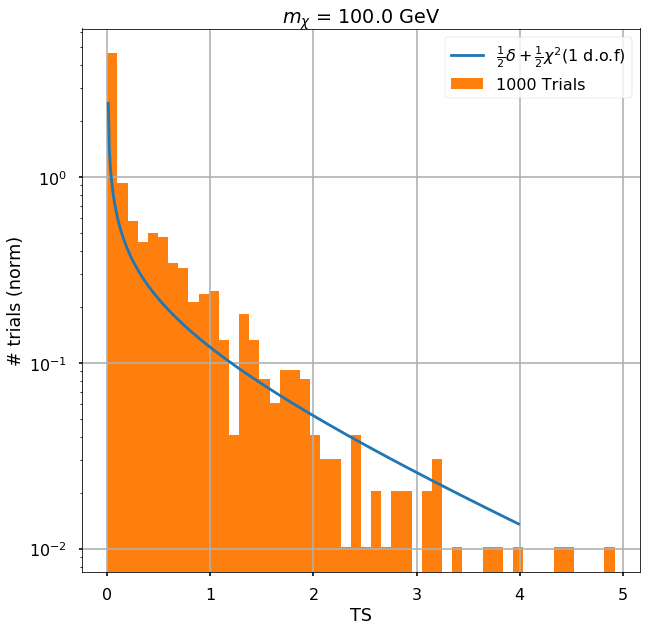

In [55]:
%matplotlib inline
from scipy.stats import chi2
x = np.arange(0, 4, 0.01)
df = 1
rv = chi2(df)

from scipy import signal
imp = signal.unit_impulse(np.size(x),1)

#bins = np.linspace(0, 10, 50)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(x, 0.5*imp + 0.5*rv.pdf(x), label =r"$\frac{1}{2}\delta + \frac{1}{2}\chi^2$(1 d.o.f)")
ax.hist(sens['TS_dist'], 50, density=True, label="%i Trials"%Ntrials)
#ax.hist(TS_sens, bins, density=True, label="%i Trials"%Ntrials, histtype="step", linewidth=5)
ax.set_yscale('log')
ax.set_title(r"$m_\chi$ = %.1f GeV"%mass)
ax.set_ylabel("# trials (norm)")
ax.set_xlabel("TS")
#ax.set_xlim(0,3)
ax.legend()
ax.grid()

In [21]:
print('Median sensitivity xs=',sens['median']*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)
print('Median Freq sensitivity xs=',mean*np.sum(hbkg[0])/np.sum(hDM[0])*10**-23)

Median sensitivity xs= 4.2653136788603375e-25
Median Freq sensitivity xs= 4.705097645765395e-25
